<a href="https://colab.research.google.com/github/tsparaskevas/DataJournalism/blob/main/Processing%20%26%20analysis%20for%20multiple%20corpora%20guide/process_and_analyze_multiple_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import spacy**

In [1]:
#!python -m spacy download el_core_news_sm

**Import libraries**

In [2]:
import pandas as pd
import numpy as np 

from google.colab import drive
drive.mount('gdrive')

from wordcloud import WordCloud, STOPWORDS

import spacy

from sklearn.feature_extraction.text import CountVectorizer

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


**Import data**

In [3]:
# adonis tweets
adonis_full_tweets_df = pd.read_csv("https://raw.githubusercontent.com/tsparaskevas/DataJournalism/main/Processing%20%26%20analysis%20for%20multiple%20corpora%20guide/AdonisGeorgiadi_tweets_all.tsv", sep="\t")
print("adonis' df size:", adonis_full_tweets_df.shape)
# aris tweets
aris_full_tweets_df = pd.read_csv("https://raw.githubusercontent.com/tsparaskevas/DataJournalism/main/Processing%20%26%20analysis%20for%20multiple%20corpora%20guide/ArisPortosalte_tweets_all.tsv", sep="\t")
print("aris' df size:", aris_full_tweets_df.shape)
# και όλα όσα tsv έχετε (π.χ. adonis_news247_full_articles_df, κλπ.)

adonis' df size: (3426, 31)
aris' df size: (3260, 31)


**Check and preprocess**

In [4]:
# check the datetime format in adonis' tweets
print("adonis' tweets date format:", adonis_full_tweets_df.loc[0, "created_at"])
# check the datetime format in aris' tweets
print("aris' tweets date format:", aris_full_tweets_df.loc[0, "created_at"])
# check the datetime format in news247's articles about adonis

# check the datetime format in news247's articles about aris

# το πιθανότερο είναι ότι στα άρθρα η ημερομηνία θα έχει άλλο format από τα tweets, επομένως θα πρέπει παρακάτω ΝΑ ΠΡΟΣΕΞΕΤΕ το format όταν μετατρέπετε σε datetime
# για τα datetime Format Codes δείτε στο τέλος αυτής της σελίδας: https://pythonprogramminglanguage.com/datetime/

adonis' tweets date format: Fri May 27 13:23:27 +0000 2022
aris' tweets date format: Tue May 24 13:50:42 +0000 2022


In [5]:
# convert 'created_at' to datetime to a new column
adonis_full_tweets_df['datetime'] = pd.to_datetime(adonis_full_tweets_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
aris_full_tweets_df['datetime'] = pd.to_datetime(aris_full_tweets_df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')

Για να προχωρήσετε παρακάτω, έχετε 2 επιλογές:
1. να ακολουθήσετε τα βήματα για καθάρισμα, wordclouds, counter vectorization και sentiement analysis όπως είναι στα notebooks του μαθήματος στο github, ΓΙΑ ΚΑΘΕΝΑ ΑΠΟ ΤΑ dataframes ΞΕΧΩΡΙΣΤΑ,

ή

2. να τα κάνετε όλα μαζί.

Παρακάτω σας δείχνω πώς να τα κάνετε όλα μαζί.

Για να τα κάνετε όλα μαζί, θα πρέπει να κάνετε merge τα dataframes. Για να το κάνετε αυτό και να μπορείτε να φιλτράρετε τα rows του κάθε df (π.χ. να μετρήσετε πόσα είναι τα tweets του άδωνη, ή να κάνετε ξεχωριστά wordclouds, sentiment analysis κλπ.) πρέπει να προσέξετε 2 πράγματα:

1. όλα τα dfs να έχουν μια στήλη 'name' με το όνομα του σώματος κειμένων (π.χ. το adonis_full_tweets_df['name'] θα πρέπει να γράφει adonis_tweets, τα άρθρα για τον άδωνη να έχουν 'name' -> adonis_articles, κ.ο.κ.)
2. όλα τα dfs να έχουν τα ίδια ονόματα στηλών πριν το merge (δεν είναι απαραίτητο, αλλά είναι λιγότερο χαοτικό)

Οπότε, ας τα κάνουμε αυτά.

In [6]:
# create 'name' column and assign an appropriate name to each dataframe
adonis_full_tweets_df['name'] = 'adonis_tweets'
aris_full_tweets_df['name'] = 'aris_tweets'

In [7]:
aris_full_tweets_df.head(1)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,lang,extended_entities,possibly_sensitive,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,datetime,name
0,Tue May 24 13:50:42 +0000 2022,1529097561117712384,1529097561117712384,"Δεν θέλουν, λένε, το μετρό στα Εξάρχεια, γιατί...",False,"[0, 111]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,NaN,...,el,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-24 13:50:42,aris_tweets


In [8]:
# rename text's column name to 'text'
adonis_full_tweets_df = adonis_full_tweets_df.rename(columns={'full_text': 'text'} )
aris_full_tweets_df = aris_full_tweets_df.rename(columns={'full_text': 'text'} )

Tip: είναι πιθανό, στα csvs από άρθρα news sites, να έχετε περισσότερες από μια στήλες κειμένου και να τις θέλετε όλες. Για παράδειγμα, μπορεί να έχετε title, summary και body. Θα πρέπει να φτιάξετε μια νέα στήλη 'text' (ή όπως αλλιώς, αρκεί να έχει το ίδιο όνομα με τη στήλη του κειμένου στα dfs των tweets), η οποία να περιέχει το κείμενο που προκύπτει από την ένωση όλων των επιμέρους στηλών κειμένων.

Αυτό γίνεται έτσι:

```
adonis_news247_full_articles_df["text"] = adonis_news247_full_articles_df["title"] + adonis_news247_full_articles_df["summary"] + adonis_news247_full_articles_df["body"]
```




In [9]:
# make a new column 'text' and put in the joined text from separate text columns

Φτιάχνουμε για κάθε full df, ένα short df, κρατώντας μόνο τις στήλες 'datetime', 'text' και 'name' 

In [10]:
# keep only the "datetime", "text" and "name" columns
adonis_short_tweets_df = adonis_full_tweets_df[['datetime', 'text', 'name']]
aris_short_tweets_df = aris_full_tweets_df[['datetime', 'text', 'name']]

Τώρα είμαστε έτοιμοι να ενώσουμε (merge) τα ξεχωριστά dfs σε ένα df (π.χ. "merged_df")

In [11]:
# merge dfs
merged_df = pd.merge(adonis_short_tweets_df, aris_short_tweets_df, how="outer", on=["datetime", "text", 'name'])
merged_df

,datetime,text,name
0,2022-05-27 13:23:27,RT @MinDevGR: Ο ΥΠΑΝΕΠ @AdonisGeorgiadi συναντ...,adonis_tweets
1,2022-05-26 19:40:30,RT @neademokratia: Στο όνομα ποιας ακαδημαϊκής...,adonis_tweets
2,2022-05-26 19:40:26,RT @neademokratia: Αντί να μιλάει για προβοκάτ...,adonis_tweets
3,2022-05-26 17:16:29,RT @neademokratia: Καλούμε τον ΣΥΡΙΖΑ να απαντ...,adonis_tweets
4,2022-05-26 17:13:14,RT @Kathimerini_gr: Χολιγουντιανή «βάση» ξανά ...,adonis_tweets
...,...,...,...
6681,2022-05-30 20:47:50,RT @ManosVoularinos: Ενδιαφέρον; Φοβερά. Ευκολ...,aris_tweets
6682,2022-05-28 17:09:44,"Ημέρα Μνήμης στον ΣΚΑΙ 100,3 Κυριακή πρωί 29ης...",aris_tweets
6683,2022-05-28 06:36:06,Αίσχος κ ντροπή ο εμπαιγμός από το Δημόσιο επι...,aris_tweets
6684,2022-05-28 06:27:24,@ArisZachos @AkiPapazoglou @Athanasiosfara1 @m...,aris_tweets


Όπως βλέπετε στο ενωμένο df, τα σχετικά με τον άδωνη tweets μπορούν να διαχωριστούν από τα υπόλοιπα, φιλτράροντας απλώς το name

In [12]:
# select only adonis tweets
merged_df[merged_df['name'] == 'adonis_tweets']

,datetime,text,name
0,2022-05-27 13:23:27,RT @MinDevGR: Ο ΥΠΑΝΕΠ @AdonisGeorgiadi συναντ...,adonis_tweets
1,2022-05-26 19:40:30,RT @neademokratia: Στο όνομα ποιας ακαδημαϊκής...,adonis_tweets
2,2022-05-26 19:40:26,RT @neademokratia: Αντί να μιλάει για προβοκάτ...,adonis_tweets
3,2022-05-26 17:16:29,RT @neademokratia: Καλούμε τον ΣΥΡΙΖΑ να απαντ...,adonis_tweets
4,2022-05-26 17:13:14,RT @Kathimerini_gr: Χολιγουντιανή «βάση» ξανά ...,adonis_tweets
...,...,...,...
3421,2022-06-03 16:46:20,@AggieV01 @KostasVaxevanis @a_loverdos Ψέματα,adonis_tweets
3422,2022-06-03 16:41:35,RT @ThePresidentGr: Χρ.Δήμας: Σημαντικές δράσε...,adonis_tweets
3423,2022-06-03 16:40:21,RT @TennisTV: HOW. JUST. HOW 🤯\n\n@RafaelNadal...,adonis_tweets
3424,2022-06-03 16:35:10,RT @Kathimerini_gr: Το δίλημμα σήμερα είναι ή ...,adonis_tweets


Πετάμε τυχόν rows με nan values

In [13]:
merged_df = merged_df.dropna()
merged_df.reset_index(drop=True, inplace=True)

In [14]:
merged_df.shape

(6686, 3)

**Cleaning**

τώρα μπορούμε να κάνουμε καθάρισμα στο merged_df κι έτσι να διώξουμε ό,τι δε θέλουμε από όλα τα κείμενα με τη μία, χωρίς να χρειάζεται να κάνουμε τα ίδια replace στο κάθε df ξεχωριστά 

In [15]:
# replace
merged_df["clean_text"] = merged_df["text"].str.replace('amp', '')

Στην περίπτωση που θέλουμε να κάνουμε replace κάτι μόνο π.χ. από τα tweets του άδωνη (π.χ. θέλουμε να διώξουμε το 'άδωνις' που μπορεί να υπάρχει στα κείμενα), το κάνουμε με φίλτρο:

In [16]:
# do specific replacements to selected rows
merged_df[merged_df['name'] == 'adonis_tweets']["clean_text"] = merged_df[merged_df['name'] == 'adonis_tweets']["clean_text"].str.replace("Άδωνις", "")
merged_df[merged_df['name'] == 'aris_tweets']["clean_text"] = merged_df[merged_df['name'] == 'aris_tweets']["clean_text"].str.replace("Άρης", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Corpora info**

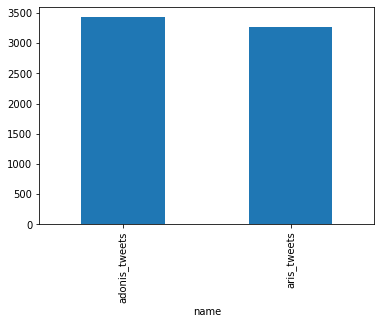

In [17]:
merged_df.groupby('name')['clean_text'].size().plot(kind="bar")

In [18]:
merged_df

,datetime,text,name,clean_text
0,2022-05-27 13:23:27,RT @MinDevGR: Ο ΥΠΑΝΕΠ @AdonisGeorgiadi συναντ...,adonis_tweets,RT @MinDevGR: Ο ΥΠΑΝΕΠ @AdonisGeorgiadi συναντ...
1,2022-05-26 19:40:30,RT @neademokratia: Στο όνομα ποιας ακαδημαϊκής...,adonis_tweets,RT @neademokratia: Στο όνομα ποιας ακαδημαϊκής...
2,2022-05-26 19:40:26,RT @neademokratia: Αντί να μιλάει για προβοκάτ...,adonis_tweets,RT @neademokratia: Αντί να μιλάει για προβοκάτ...
3,2022-05-26 17:16:29,RT @neademokratia: Καλούμε τον ΣΥΡΙΖΑ να απαντ...,adonis_tweets,RT @neademokratia: Καλούμε τον ΣΥΡΙΖΑ να απαντ...
4,2022-05-26 17:13:14,RT @Kathimerini_gr: Χολιγουντιανή «βάση» ξανά ...,adonis_tweets,RT @Kathimerini_gr: Χολιγουντιανή «βάση» ξανά ...
...,...,...,...,...
6681,2022-05-30 20:47:50,RT @ManosVoularinos: Ενδιαφέρον; Φοβερά. Ευκολ...,aris_tweets,RT @ManosVoularinos: Ενδιαφέρον; Φοβερά. Ευκολ...
6682,2022-05-28 17:09:44,"Ημέρα Μνήμης στον ΣΚΑΙ 100,3 Κυριακή πρωί 29ης...",aris_tweets,"Ημέρα Μνήμης στον ΣΚΑΙ 100,3 Κυριακή πρωί 29ης..."
6683,2022-05-28 06:36:06,Αίσχος κ ντροπή ο εμπαιγμός από το Δημόσιο επι...,aris_tweets,Αίσχος κ ντροπή ο εμπαιγμός από το Δημόσιο επι...
6684,2022-05-28 06:27:24,@ArisZachos @AkiPapazoglou @Athanasiosfara1 @m...,aris_tweets,@ArisZachos @AkiPapazoglou @Athanasiosfara1 @m...


**Count vectorizer (for every separate corpora)**

In [19]:
# load spacy nlp
nlp = spacy.load('el_core_news_sm')

Φτιάχνετε όποιον και όσους vectorizers θέλετε

In [20]:
# vectorizer 
cv = CountVectorizer(stop_words= nlp.Defaults.stop_words, max_features=20, ngram_range=(2, 2))

In [21]:
# adonis tweets
count_vector = cv.fit_transform(merged_df[merged_df['name'] == 'adonis_tweets']['clean_text'])
adonis_tweets_results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out()) 
adonis_tweets_results.head(1)

,adonisgeorgiadi συναντήθηκε,https co,mindevgr υπουργός,of the,rt amna_news,rt capitalgr,rt ellada24,rt ellinikiagogi,rt grigoris_d,rt kathimerini_gr,rt kyvernitiparat1,rt mindevgr,rt oknewsgr,rt primeministergr,rt skaigr,rt spectatorindex,spectatorindex breaking,ανάπτυξης επενδύσεων,επενδύσεων adonisgeorgiadi,υπουργός ανάπτυξης
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Βλέπετε μπούρδες γιατί δεν έχω κάνει καθάρισμα. Εννοείται ότι εσείς έχετε κάνει νωρίτερα το καθάρισμα. Σας έχω δώσει οδηγίες και στο μνμ "Κάποιες γενικές παρατηρήσεις για το καθάρισμα και το wordcloud" που σας έστειλα μέσω eClass.

In [22]:
import matplotlib.pyplot as plt

#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

Μπορείτε να κάνετε γραφήματα του πλήθους των λέξεων (sum) με τον κώδικα που έχετε από τα notebooks του μαθήματος στο github. Παρακάτω σας δείχνω και πώς μπορείτε να το κάνετε με ποσοστό.

Text(0.5, 0, '% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

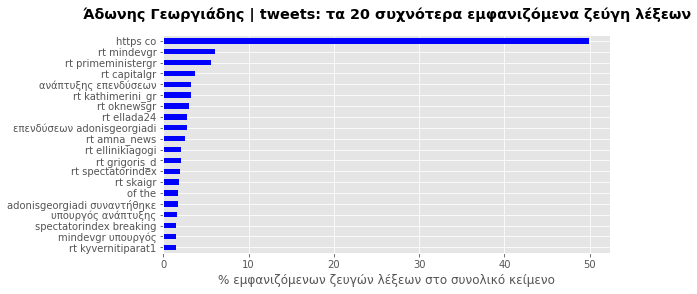

In [23]:
# adonis tweets words graph with %
adonis_tweets_words =  adonis_tweets_results.sum(axis =0)
adonis_tweets_words_percent = adonis_tweets_words.sort_values(ascending = False).head(20) / adonis_tweets_words.sum() * 100

ax = adonis_tweets_words_percent.plot(kind='barh', figsize=(8,4), color = 'blue', xlabel='').invert_yaxis()
plt.title('Άδωνης Γεωργιάδης | tweets: τα 20 συχνότερα εμφανιζόμενα ζεύγη λέξεων', y=1.05, fontweight='bold')
plt.xlabel('% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

To ίδιο κάνουμε και για τα υπόλοιπα σώματα κειμένων

In [24]:
# aris tweets
count_vector = cv.fit_transform(merged_df[merged_df['name'] == 'aris_tweets']['clean_text'])
aris_tweets_results = pd.DataFrame(count_vector.toarray(), columns=cv.get_feature_names_out()) 
aris_tweets_results.head(1)

,adonisgeorgiadi fontasts,adonisgeorgiadi manolidoue,akipapazoglou peristerara,ariszachos athanasiosfara1,athanasiosfara1 nikospagopoulos,cmouroutis fontasts,fontasts gpapageorgiadis,fontasts nikospagopoulos,gpapageorgiadis adonisgeorgiadi,johnkanellopo akipapazoglou,liberalgreek ariszachos,lkousoulis καλημέρα,manolidoue lkousoulis,manolidoue s_ntornta,nikospagopoulos johnkanellopo,nikospagopoulos manolidoue,peristerara myrtozax,s_ntornta cmouroutis,s_ntornta lkousoulis,διαδικτυακής παρέας
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0.5, 0, '% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

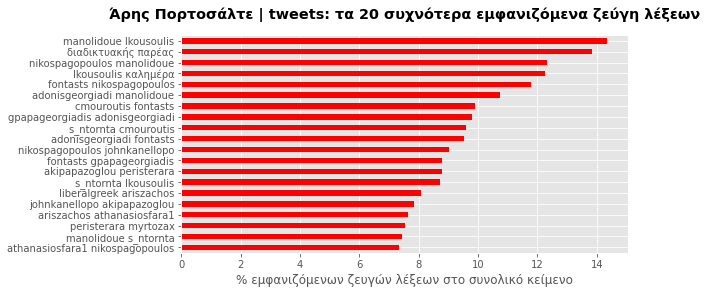

In [25]:
# aris tweets words graph with %
aris_tweets_words =  aris_tweets_results.sum(axis =0)
aris_tweets_words_percent = aris_tweets_words.sort_values(ascending = False).head(20) / adonis_tweets_words.sum() * 100

ax = aris_tweets_words_percent.plot(kind='barh', figsize=(8,4), color = 'red', xlabel='').invert_yaxis()
plt.title('Άρης Πορτοσάλτε | tweets: τα 20 συχνότερα εμφανιζόμενα ζεύγη λέξεων', y=1.05, fontweight='bold')
plt.xlabel('% εμφανιζόμενων ζευγών λέξεων στο συνολικό κείμενο')

**Wordclouds**

Εδώ σας δείχνω πώς μπορείτε να κάνετε wordcloud ενός μόνο σώματος κειμένων από το merged_df, και επίσης χωρίς να κάνετε πρώτα join το text των επιμέρους tweets (το join γίνεται την ώρα που γίνεται generate το wordcloud)

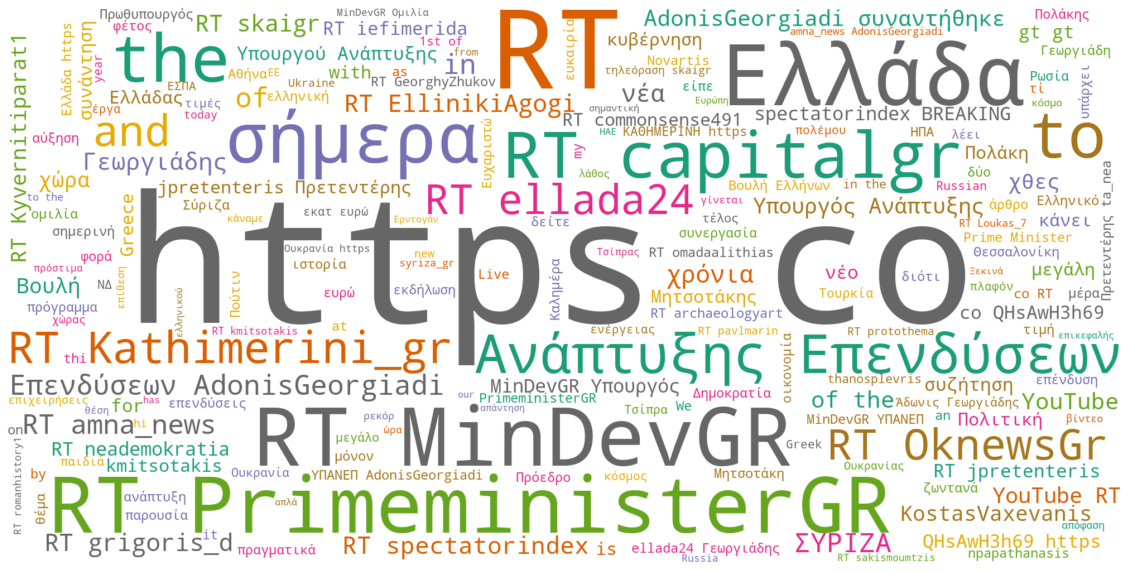

In [26]:
wordcloud1 = WordCloud(
      stopwords = nlp.Defaults.stop_words,
      max_words=200,
      width = 2000,
      height = 1000,
      background_color='white',
      contour_color = 'gray',
      colormap='Dark2', #'tab10',#Dark2
      contour_width = 1
      ).generate(merged_df[merged_df['name'] == 'adonis_tweets']['clean_text'].str.cat(sep = ' '))
fig = plt.figure(
      figsize = (20, 15),
      #facecolor = 'r',
      #edgecolor = 'r'
      )
plt.imshow(wordcloud1, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

Κι αν θέλετε να κάνετε lemmatization, πάλι μπορείτε να το κάνετε μέσα στο generate - αντί να το κάνετε πρώτα)

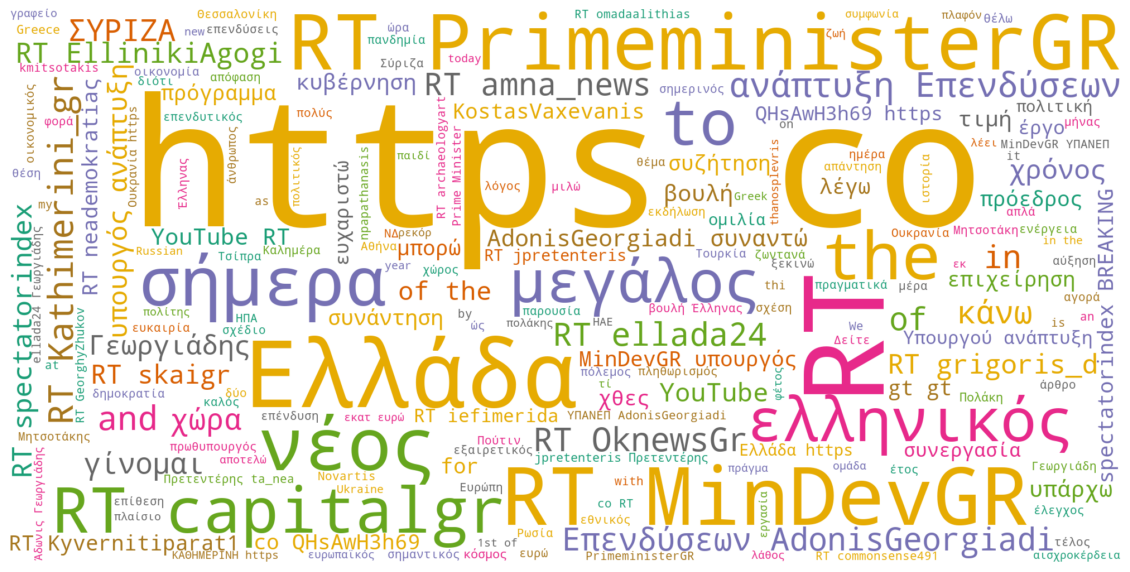

In [27]:
wordcloud1 = WordCloud(
      stopwords = nlp.Defaults.stop_words,
      max_words=200,
      width = 2000,
      height = 1000,
      background_color='white',
      contour_color = 'gray',
      colormap='Dark2', #'tab10',#Dark2
      contour_width = 1
      ).generate(' '.join(token.lemma_ for token in nlp(merged_df[merged_df['name'] == 'adonis_tweets']['clean_text'].str.cat(sep = ' '))))
fig = plt.figure(
      figsize = (20, 15),
      #facecolor = 'r',
      #edgecolor = 'r'
      )
plt.imshow(wordcloud1, interpolation = 'bilinear')
plt.axis('off')
#plt.tight_layout(pad=0)
plt.show()

Το ίδιο κάνετε μετά για τα tweets του Πορτοσάλτε και ό,τι άλλο έχετε. 

**Cosine similarity**

Μπορούμε να πάμε κατευθείαν στο tfidf

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words= nlp.Defaults.stop_words, max_features=500)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(merged_df['clean_text'])  #finds the tfidf score with normalization
texts_results = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) 
texts_results.head()

,00,000,08,09,10,100,11,12,13,15,...,χρόνια,χρόνο,χρόνου,χώρα,χώρας,χώρες,χώρο,ψέματα,ψυχραιμία,ώρα
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.594144,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
arr1 = cosine_similarity(tfidf_matrix_train, tfidf_matrix_train)

Τώρα μποροείτε να δείτε ποια κείμενα μοιάζουν μεταξύ τους. Βάζοντας στο .loc έναν αριθμό row (στην περίπτωσή μας ένα tweet), βλέπουμε με ποια άλλα tweets μοιάζει. Από τον παρακάτω κώδικα, βλέπουμε ότι το tweet 0, εκτός από τον εαυτό του μοιάζει και με το 2985 και το 518 και το 1697 και το 1911.

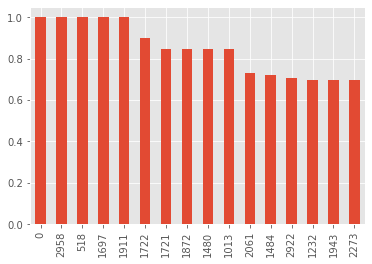

In [31]:
pd.DataFrame(arr1).loc[0].sort_values(ascending = False).head(16).plot(kind = 'bar')

Μπορούμε να δούμε τι λένε αυτά τα tweets.

In [32]:
print(merged_df.loc[0, 'clean_text'])
print(merged_df.loc[2958, 'clean_text'])
print(merged_df.loc[518, 'clean_text'])
print(merged_df.loc[1697, 'clean_text'])
print(merged_df.loc[1911, 'clean_text'])

RT @MinDevGR: Ο ΥΠΑΝΕΠ @AdonisGeorgiadi συναντήθηκε με τον Δήμαρχο Ελευσίνας, κ. Αργύρη Οικονόμου και τον A’ Επιλαχόντα Βουλευτή Δυτικής Ατ…
RT @MinDevGR: Ο ΥΠΑΝΕΠ @AdonisGeorgiadi συναντήθηκε με τον Βουλευτή Αρκαδίας, τ. υφυπουργό, Κώστα Βλάσση &; τον Δήμαρχο Βόρειας Κυνουρίας, Γ…
RT @MinDevGR: Ο ΥΠΑΝΕΠ @AdonisGeorgiadi συναντήθηκε με τον Βουλευτή του Ουκρανικού Κοινοβουλίου και Ιδρυτή της Smart Holding, Vadym Novynsk…
RT @MinDevGR: O ΥΠΑΝΕΠ @AdonisGeorgiadi συναντήθηκε με τον Δήμαρχο Ελευσίνας, κ. Αργύρη Οικονόμου και τον Α’ επιλαχόντα Βουλευτή Δυτικής Ατ…
RT @MinDevGR: Ο ΥΠΑΝΕΠ @AdonisGeorgiadi συναντήθηκε με τον Βουλευτή Ανατολικής Αττικής @OikonomouVasili και τον Δήμαρχο Λαυρεωτικής, κ. Δημ…


Στην περίπτωσή μας αυτό δε λέει και πολλά - περισσότερο νόημα έχει να δούμε πόσο μοιάζουν όχι ένα-ένα τα tweets μεταξύ τους, αλλά πόσο μοιάζουν τα σώματα κειμένων μεταξύ τους.

Για να το κάνουμε αυτό πρέπει να ενώσουμε όλα τα ομοειδή tweets σε ένα μακρινάρι κείμενο. 

Ένας τρόπος είναι να φτιάξουμε ένα dictionary και μετά να το κάνουμε df

In [33]:
# create an empty dictionary to store joined tweets' text
corpora_dict = {}
# add adonis tweets corpus to dictionary
corpora_dict['adonis_tweets'] = merged_df[merged_df['name'] == 'adonis_tweets']['clean_text'].str.cat(sep = ' ')
# add websites suicide corpus to dictionary
corpora_dict['aris_tweets'] = merged_df[merged_df['name'] == 'aris_tweets']['clean_text'].str.cat(sep = ' ')
# create corpora dataframe from dictionary
corpora_df = pd.DataFrame.from_dict(corpora_dict, orient = 'index')
# rename column name to 'text'
corpora_df.rename(columns = {0:'text'}, inplace = True)

In [34]:
corpora_df

,text
adonis_tweets,RT @MinDevGR: Ο ΥΠΑΝΕΠ @AdonisGeorgiadi συναντ...
aris_tweets,"Δεν θέλουν, λένε, το μετρό στα Εξάρχεια, γιατί..."


In [35]:
tfidf_matrix_train = tfidf_vectorizer.fit_transform(corpora_df['text'])  #finds the tfidf score with normalization
corpora_results = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) 
corpora_results.head()

,00,000,08,09,10,100,11,12,13,15,...,χρόνια,χρόνο,χρόνου,χώρα,χώρας,χώρες,χώρο,ψέματα,ψυχραιμία,ώρα
0,0.013089,0.015494,0.006678,0.003473,0.006411,0.004274,0.005076,0.005343,0.004808,0.005877,...,0.022172,0.002137,0.000267,0.013891,0.005610,0.003473,0.003206,0.002137,0.000534,0.005076
1,0.020755,0.002767,0.005930,0.007907,0.011267,0.021545,0.004744,0.003163,0.001384,0.006128,...,0.033603,0.006128,0.006523,0.003163,0.001384,0.005732,0.002372,0.005732,0.006325,0.008500


In [36]:
arr2 = cosine_similarity(tfidf_matrix_train, tfidf_matrix_train)

Κι έτσι μπορούμε να δούμε πόσο μοιάζουν μεταξύ τους τα σώματα κειμένων

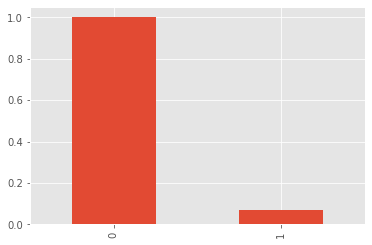

In [37]:
pd.DataFrame(arr2).loc[0].sort_values(ascending = False).head(20).plot(kind = 'bar')

**Sentiment analysis (θα το κάνουμε με το corpora_df)**

Πρώτα "παίζουμε" με το emolex

In [38]:
# read emolex file
filepath = "https://raw.githubusercontent.com/datajour-gr/Data_journalism/master/week10/NRC_GREEK_Translated_6_2020.csv"
emolex_df = pd.read_csv(filepath)

# drop duplicates and NaNs
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(drop=True, inplace = True)

# transform to lower
emolex_df['word'] = emolex_df['word'].str.lower()

emolex_df.head(1)

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
emolex_df['word'] = emolex_df['word'].str.lower()

In [40]:
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word, 
                      strip_accents = 'unicode',  
                      stop_words= nlp.Defaults.stop_words,
                      ngram_range=(1, 2))

In [41]:
# Create lists with polarized emolex words
emolex_df.columns

Index(['word', 'Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust',
       'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust'],
      dtype='object')

positive/negative lists

In [42]:
# Φτιάξε μια λίστα με positive words
positive_words = emolex_df[emolex_df.Positive == 1]['word']

# Φτιάξε μια λίστα με negative words
negative_words = emolex_df[emolex_df.Negative == 1]['word']

emotions lists

In [43]:
# Φτιάξε μια λίστα με anger words
angry_words = emolex_df[emolex_df.Anger == 1]['word']

# Φτιάξε μια λίστα με anticipation words
anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']

# Φτιάξε μια λίστα με disgust words
disgust_words = emolex_df[emolex_df.Disgust == 1]['word']

# Φτιάξε μια λίστα με fear words
fear_words = emolex_df[emolex_df.Fear == 1]['word']

# Φτιάξε μια λίστα με joy words
joy_words = emolex_df[emolex_df.Joy == 1]['word']

# Φτιάξε μια λίστα με sadness words
sadness_words = emolex_df[emolex_df.Sadness == 1]['word']

# Φτιάξε μια λίστα με surprise words
surprise_words = emolex_df[emolex_df.Surprise == 1]['word']

# Φτιάξε μια λίστα με trust words
trust_words = emolex_df[emolex_df.Trust == 1]['word']

Κάνουμε sentiment analysis για το κάθε σώμα κειμένων

Ξεχωρίζουμε τα σώματα κειμένων από το merged_df (σ'αυτά τα df, θα βάλουμε μετά index το datetime).

In [85]:
# παίρνω μόνο το datetime και το clean_text
adonis_tweets_df_dt = merged_df[merged_df['name'] == 'adonis_tweets'][['datetime', 'clean_text']].copy(deep=True)
adonis_tweets_df_dt.reset_index(inplace=True)

In [86]:
# παίρνω μόνο το datetime και το clean_text
aris_tweets_df_dt = merged_df[merged_df['name'] == 'aris_tweets'][['datetime', 'clean_text']].copy(deep=True)
aris_tweets_df_dt.reset_index(inplace=True)

**Άδωνης tweets**

In [87]:
matrix = vec.fit_transform(adonis_tweets_df_dt['clean_text'])
vocab = vec.get_feature_names_out()
word_count_adonis_tweets_df = pd.DataFrame(matrix.toarray(), columns=vocab)
word_count_adonis_tweets_df.head(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create columns with sentiment scores

In [88]:
# positive/negative
adonis_tweets_df_dt['positivity'] = word_count_adonis_tweets_df[positive_words].sum(axis=1)
adonis_tweets_df_dt['negativity'] = word_count_adonis_tweets_df[negative_words].sum(axis=1)

In [89]:
# emotions

adonis_tweets_df_dt['anger'] = word_count_adonis_tweets_df[angry_words].sum(axis=1)
adonis_tweets_df_dt['anticipation'] = word_count_adonis_tweets_df[anticipation_words].sum(axis=1)
adonis_tweets_df_dt['disgust'] = word_count_adonis_tweets_df[disgust_words].sum(axis=1)
adonis_tweets_df_dt['fear'] = word_count_adonis_tweets_df[fear_words].sum(axis=1)
adonis_tweets_df_dt['joy'] = word_count_adonis_tweets_df[joy_words].sum(axis=1)
adonis_tweets_df_dt['sadness'] = word_count_adonis_tweets_df[sadness_words].sum(axis=1)
adonis_tweets_df_dt['surprise'] = word_count_adonis_tweets_df[surprise_words].sum(axis=1)
adonis_tweets_df_dt['trust'] = word_count_adonis_tweets_df[trust_words].sum(axis=1)

In [90]:
adonis_tweets_df_dt.head(2)

,index,datetime,clean_text,positivity,negativity,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,0,2022-05-27 13:23:27,RT @MinDevGR: Ο ΥΠΑΝΕΠ @AdonisGeorgiadi συναντ...,0,0,0,0,0,0,0,0,0,0
1,1,2022-05-26 19:40:30,RT @neademokratia: Στο όνομα ποιας ακαδημαϊκής...,0,2,1,0,1,0,0,0,0,1


Κάνουμε το ίδιο για τον Πορτοσάλτε (και ό,τι άλλο έχουμε)

**Άρης tweets**

In [91]:
matrix = vec.fit_transform(aris_tweets_df_dt['clean_text'])
vocab = vec.get_feature_names_out()
word_count_aris_tweets_df = pd.DataFrame(matrix.toarray(), columns=vocab)
word_count_aris_tweets_df.head(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
# positive/negative
aris_tweets_df_dt['positivity'] = word_count_aris_tweets_df[positive_words].sum(axis=1)
aris_tweets_df_dt['negativity'] = word_count_aris_tweets_df[negative_words].sum(axis=1)

In [94]:
# emotions

aris_tweets_df_dt['anger'] = word_count_aris_tweets_df[angry_words].sum(axis=1)
aris_tweets_df_dt['anticipation'] = word_count_aris_tweets_df[anticipation_words].sum(axis=1)
aris_tweets_df_dt['disgust'] = word_count_aris_tweets_df[disgust_words].sum(axis=1)
aris_tweets_df_dt['fear'] = word_count_aris_tweets_df[fear_words].sum(axis=1)
aris_tweets_df_dt['joy'] = word_count_aris_tweets_df[joy_words].sum(axis=1)
aris_tweets_df_dt['sadness'] = word_count_aris_tweets_df[sadness_words].sum(axis=1)
aris_tweets_df_dt['surprise'] = word_count_aris_tweets_df[surprise_words].sum(axis=1)
aris_tweets_df_dt['trust'] = word_count_aris_tweets_df[trust_words].sum(axis=1)

In [95]:
aris_tweets_df_dt.head(2)

,index,datetime,clean_text,positivity,negativity,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,3426,2022-05-24 13:50:42,"Δεν θέλουν, λένε, το μετρό στα Εξάρχεια, γιατί...",0,0,0,0,0,0,0,0,0,0
1,3427,2022-05-22 09:28:37,Πολιτικούς που δεν μασάνε τα λόγια τους και δε...,3,2,2,1,1,0,0,0,0,0


Και στο τέλος μπορούμε να κάνουμε ό,τι γραφήματα θέλουμε.

Μπορούμε να κάνουμε index το datetime για να δούμε την ημερισια μεταβολή.

In [96]:
# set datetime as index - adonis
adonis_tweets_df_dt = adonis_tweets_df_dt.set_index('datetime')

In [97]:
# set datetime as index - aris
aris_tweets_df_dt = aris_tweets_df_dt.set_index('datetime')

Σύγκριση θετικότητας στα tweets του Άδωνη και του Πορτοσάλτε στο πέρασμα των ημερών

<Figure size 432x288 with 0 Axes>

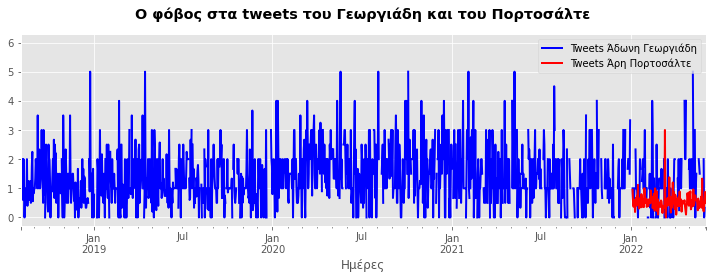

In [98]:
# compare fear
fig=plt.figure()

mylabels = ["Tweets Άδωνη Γεωργιάδη", "Tweets Άρη Πορτοσάλτε"]
ax = aris_tweets_df_dt[['positivity']].resample('D').mean().plot(figsize=(10,4), color="blue", linewidth=2.0)
adonis_tweets_df_dt[['positivity']].resample('D').mean().plot(ax=ax, color="red", linewidth=2.0)

plt.xlabel("Ημέρες")
plt.title('Ο φόβος στα tweets του Γεωργιάδη και του Πορτοσάλτε', y=1.05, fontweight='bold')
plt.xticks(rotation=0)
ax.legend(labels=mylabels)
plt.tight_layout()